# Proyecto 03
## Visión Por Computadora

In [36]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [37]:
images_dir = 'imagenes/'
input_dir = 'input0'

(-0.5, 1655.5, 1069.5, -0.5)

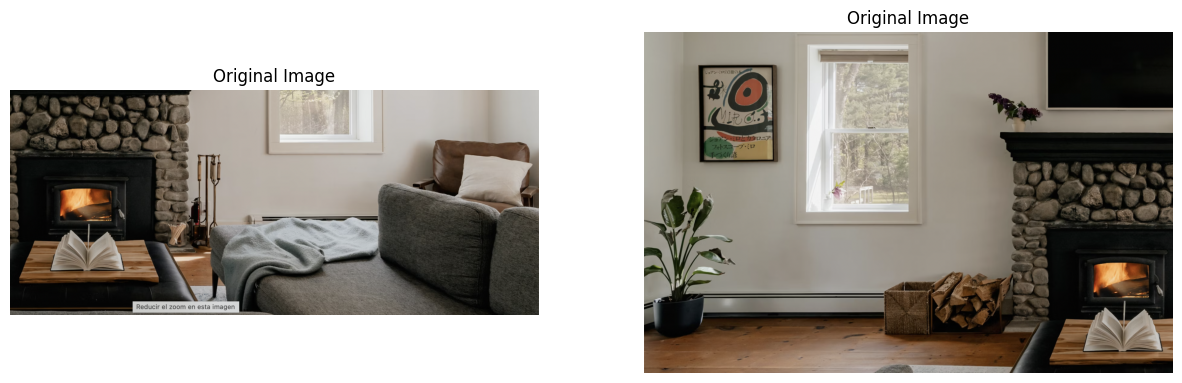

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
image_1 = cv2.imread(os.path.join(images_dir, input_dir, 's22.png'))
ax[0].imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[0].axis('off')

image_2 = cv2.imread(os.path.join(images_dir, input_dir, 's11.png'))
ax[1].imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
ax[1].set_title('Original Image')
ax[1].axis('off')


### 2

In [39]:
def find_homography(image_1_data, image_2_data):
    sift = cv2.xfeatures2d.SIFT_create()

    keypoints_1, descriptors_1 = sift.detectAndCompute(image_1_data, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image_2_data, None)

    brute_force_matcher = cv2.BFMatcher()
    matches = brute_force_matcher.knnMatch(descriptors_1, descriptors_2, k=2)
    good_matches = np.asarray([m for m in matches if m[0].distance < 0.7 * m[1].distance])

    MIN_MATCH_COUNT = 10
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([keypoints_1[m.queryIdx].pt for m in good_matches[:, 0]]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_2[m.trainIdx].pt for m in good_matches[:, 0]]).reshape(-1, 1, 2)

        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H

    else: print(f"Not enough matches' - {len(good_matches)/MIN_MATCH_COUNT}")


In [40]:
homography_12 = find_homography(image_1, image_2)

### 3

In [41]:
def warping(img1, img2, homography):
    height_img1, width_img1, _ = img1.shape
    height_img2, width_img2, _ = img2.shape

    img1_warped = cv2.warpPerspective(img1, homography, (width_img1 + width_img2, height_img2))
    img1_warped[0:height_img2, 0:width_img2] = img2

    return img1_warped

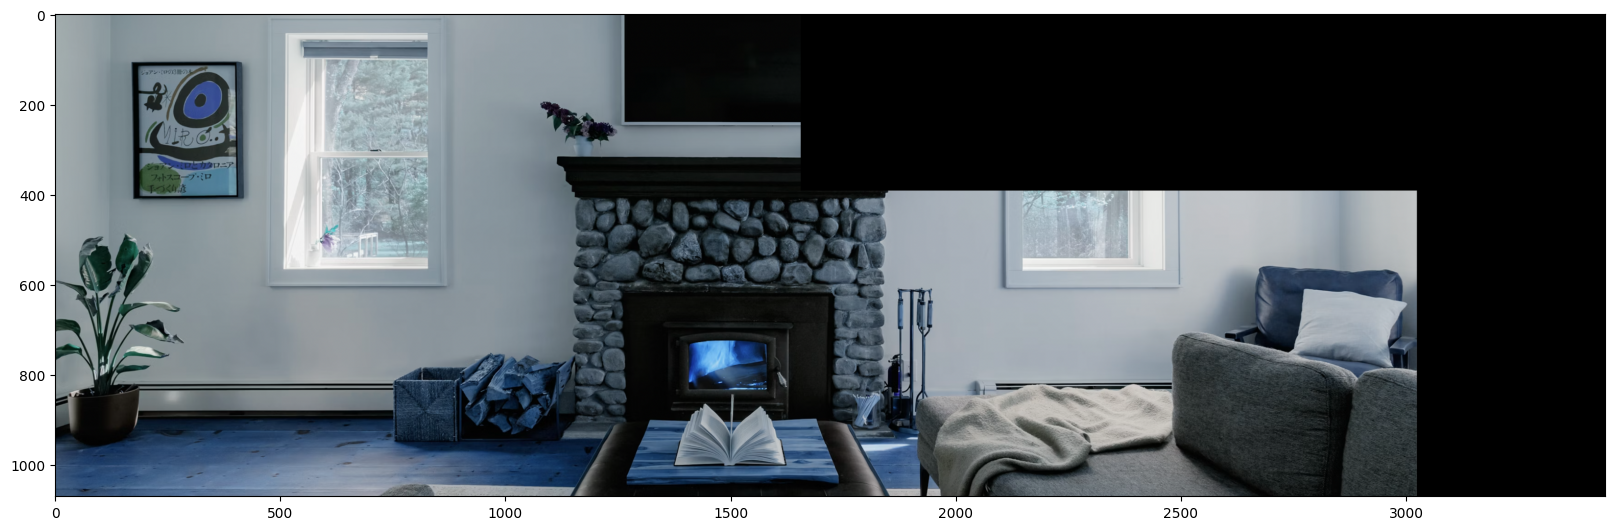

In [42]:
warped_img = warping(image_1, image_2, homography_12)

plt.figure(figsize=(20,10))
plt.imshow(warped_img)
plt.show()